<a href="https://colab.research.google.com/github/elylaila/seminario/blob/main/hate_ita_xlm_r_base_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

!{sys.executable} -m pip install transformers[torch] datasets evaluate torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertConfig, AutoConfig
import numpy as np
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Seminario

/content/drive/MyDrive/Seminario


# Data loading

In [5]:
df_dev = load_dataset("csv", data_files="dataset/df_train_clean.csv")
# df_test = load_dataset("csv", data_files="dataset/subtaskA_clean_test_cased.csv")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

# Data partioning

In [6]:
dev = df_dev['train'].train_test_split(test_size=0.3, seed=42)
dev

DatasetDict({
    train: Dataset({
        features: ['text', 'homotransphobic'],
        num_rows: 3500
    })
    test: Dataset({
        features: ['text', 'homotransphobic'],
        num_rows: 1500
    })
})

In [7]:
df_train = dev["train"]
df_val = dev["test"]

In [8]:
df_train = df_train.rename_column("homotransphobic", "labels")
df_val = df_val.rename_column("homotransphobic", "labels")

# Model loading

In [9]:
nome = 'hate-ita-xlm-r-base' # modificare
modello = 'MilaNLProc/hate-ita-xlm-r-base'

In [10]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(modello)

# Data preprocessing

In [11]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [12]:
tokenized_train = df_train.map(tokenize_function, batched=True)
tokenized_val = df_val.map(tokenize_function, batched=True)
# tokenized_test = df_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/3500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

# Training

In [13]:
training_args = TrainingArguments(
    output_dir=f"{nome}-finetuned",
    evaluation_strategy = "epoch", # monitor the evaluation metrics during fine-tuning at the end of each epoch
    save_strategy = "epoch",
    logging_strategy="epoch",
    num_train_epochs=10,
    load_best_model_at_end=True, # the best model might not be the one at the end of training => we load the best saved model
    metric_for_best_model='eval_f1',
    seed=42,
    # per_device_train_batch_size = 2, # default 8
    # per_device_eval_batch_size = 2 # default 8
    #learning_rate=0.0005, # default 0.00005
    #weight_decay=0.0001 # default 0 # disastro
    )

In [14]:
config = AutoConfig.from_pretrained(modello)

In [15]:
# config.dropout = 0.001

In [16]:
print(config)

XLMRobertaConfig {
  "_name_or_path": "MilaNLProc/hate-ita-xlm-r-base",
  "adapters": {
    "adapters": {},
    "config_map": {},
    "fusion_config_map": {},
    "fusions": {}
  },
  "architectures": [
    "XLMRobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "non-hateful",
    "1": "hateful"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "hateful": 1,
    "non-hateful": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.33.3",
  "type_vocab_size": 1,
  "use_cach

In [17]:
model = AutoModelForSequenceClassification.from_pretrained(modello, config=config)

model

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

In [18]:
def compute_metrics(eval_pred):
  # takes as input model predictions, applies argmax to them and comput F-Score between predictions and true labels
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics
)

In [20]:
%%time
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.624600,0.555137,0.719881
2,0.587200,0.540320,0.750441
3,0.556900,0.692623,0.568174
4,0.540100,0.602222,0.756952
5,0.479600,0.505894,0.751174
6,0.414000,0.651326,0.771178
7,0.342100,0.877233,0.750493
8,0.292500,0.900299,0.762769
9,0.251000,1.102515,0.758918
10,0.222500,1.094857,0.764009


CPU times: user 1h 3min 49s, sys: 1min 1s, total: 1h 4min 50s
Wall time: 1h 10min


TrainOutput(global_step=4380, training_loss=0.4310463979363986, metrics={'train_runtime': 4200.0657, 'train_samples_per_second': 8.333, 'train_steps_per_second': 1.043, 'total_flos': 9208886937600000.0, 'train_loss': 0.4310463979363986, 'epoch': 10.0})

# Evaluation

In [21]:
log_history = trainer.state.log_history

In [22]:
df = pd.DataFrame(columns=["Epoch", "Loss", "Dataset"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df_train = pd.DataFrame({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, index=[0])
    df = pd.concat([df, df_train], ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df_val = pd.DataFrame({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, index=[0])
    df = pd.concat([df, df_val], ignore_index=True)
df


,Epoch,Loss,Dataset
0,1,0.624600,Training
1,1,0.555137,Validation
2,2,0.587200,Training
3,2,0.540320,Validation
4,3,0.556900,Training
5,3,0.692623,Validation
6,4,0.540100,Training
7,4,0.602222,Validation
8,5,0.479600,Training
9,5,0.505894,Validation


In [23]:
from transformers.modelcard import parse_log_history

In [24]:
his = parse_log_history(log_history)


In [25]:
df_his = pd.DataFrame(his[1], columns=['Step','Epoch', 'Training Loss', 'Validation Loss', 'F1'])

In [26]:
df_his

,Step,Epoch,Training Loss,Validation Loss,F1
0,438,1.0,0.6246,0.555137,0.719881
1,876,2.0,0.5872,0.540320,0.750441
2,1314,3.0,0.5569,0.692623,0.568174
3,1752,4.0,0.5401,0.602222,0.756952
4,2190,5.0,0.4796,0.505894,0.751174
5,2628,6.0,0.4140,0.651326,0.771178
6,3066,7.0,0.3421,0.877233,0.750493
7,3504,8.0,0.2925,0.900299,0.762769
8,3942,9.0,0.2510,1.102515,0.758918
9,4380,10.0,0.2225,1.094857,0.764009


In [27]:
df.to_html(f'loss_{nome}.html')

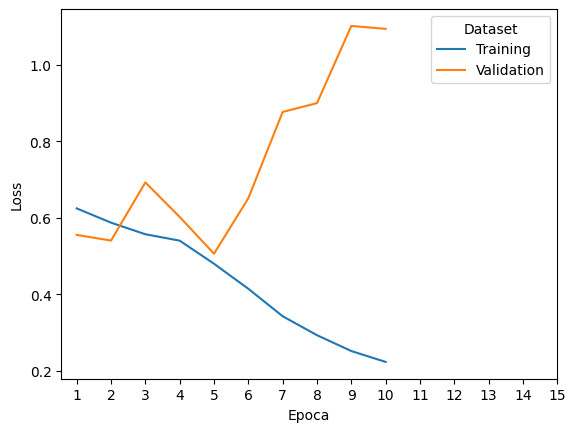

In [28]:
# loss lineplot
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Dataset")
plt.xticks(range(1, 16))
plt.xlabel('Epoca')
plt.savefig(f'loss_curves_{nome}.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
output_predictions = trainer.predict(tokenized_val)

In [30]:
y_val = tokenized_val["labels"]
y_val_pred = np.argmax(output_predictions.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       900
           1       0.73      0.71      0.72       600

    accuracy                           0.78      1500
   macro avg       0.77      0.77      0.77      1500
weighted avg       0.78      0.78      0.78      1500



In [31]:
with open(f"class_report_{nome}.html", "w") as file:
    file.write(report)

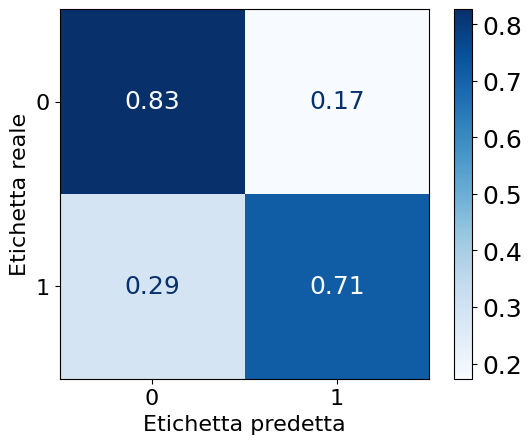

In [32]:
plt.rcParams.update({'font.size': 18})
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, cmap='Blues', normalize='true')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Etichetta predetta', fontsize=16)
plt.ylabel('Etichetta reale', fontsize=16)
plt.savefig(f'conf_matrix_{nome}.pdf', dpi=300, bbox_inches='tight')
plt.show()